# LOAD Modules

In [1]:
%matplotlib inline
#%matplotlib widget
%load_ext autoreload
%autoreload 2


import numpy as np
from visualisations import eeg_sample_plot, events_distribution_plot
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader
from datasets import ChannelsVoltageDataset
from neural_nets.nn_models_getter import get_nn_model
from optimizers import get_optimizer
from utils_train import fit, test, plot_all_metrics, plot_val_metrics
from configs import configs_ozhan, configs_tim, configs_joaquin
from data_loader_creation import get_dataloader_objects
from classification_results import results_storer



# Select the configuration

In [2]:
""" USER: SELECT THE CONFIGURATION YOU NEED """
#myList = configs_tim.list_of_configs
#myList = configs_joaquin.list_of_configs
myList = configs_ozhan.list_of_configs

# Train

Data is being loaded using MNE...
We are not on the cluster...
Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
3723 events found
Event IDs: [1 2 3]
...data loading with MNE was finished. 

cuda will be used for training of this model.
You have 2 GPUs for training!
Learning Rate:  0.001
Epoch 1/30: train_loss: 1.0815, train_accuracy: 44.0133, val_loss: 1.0487, val_accuracy: 48.0597
Epoch 2/30: train_loss: 0.9606, train_accuracy: 57.3466, val_loss: 1.0303, val_accuracy: 52.2388
Epoch 3/30: train_loss: 0.8811, train_accuracy: 66.2355, val_loss: 1.0051, val_accuracy: 55.2239
Epoch 4/30: train_loss: 0.8050, train_accuracy: 72.3715, val_loss: 0.9717, val_accuracy: 56.1194
Epoch 5/30: train_loss: 0.7386, train_accuracy: 76.3516, val_loss: 0.9746, val_accuracy: 57.0149
Epoch 6/30: train_loss: 0.6808, train_accuracy: 79.8342, val_loss: 0.9629, val_accuracy: 60.0000
Epoch 7/30: train

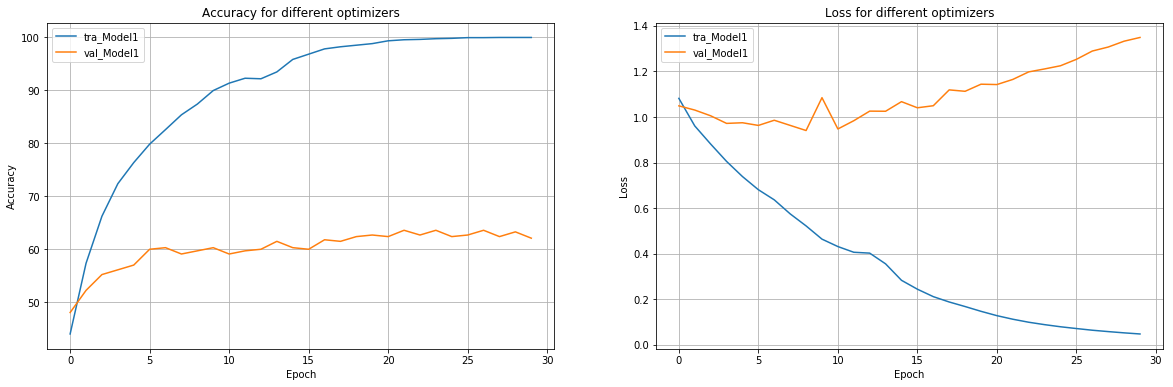

In [3]:
for my_cfg in myList:
    """ PREPARE DATALOADERS """
    train_dl, val_dl, test_dl, input_dimension_, output_dimension_ = get_dataloader_objects(my_cfg)


    """CLASSIFICATION"""
    # Get the model
    model_untrained = get_nn_model(my_cfg.nn_list[my_cfg.nn_selection_idx], input_dimension=input_dimension_,
                                   output_dimension=output_dimension_)

    # Get the optimizer
    optimizer = get_optimizer(my_cfg.optimizer_list[my_cfg.optimizer_selection_idx], my_cfg.learning_rate,
                              model_untrained.parameters(), my_cfg.momentum, my_cfg.weight_decay)

    # Train and show validation loss
    train_losses, train_accuracies, val_losses, val_accuracies, model_trained, time_spent_for_training_s =\
        fit(train_dl, val_dl, model_untrained, optimizer, my_cfg.loss_fn, my_cfg.num_of_epochs)
    
    training_curves = {}
    curves = train_losses, train_accuracies, val_losses, val_accuracies, model_trained, time_spent_for_training_s
    training_curves['Model1'] = curves
    plot_all_metrics(training_curves)
    
    # Test the net
    test_loss, test_accuracy = test(model_trained, test_dl, my_cfg.loss_fn, print_loss=True)

    # Store the results
    results_storer.store_results(my_cfg, model_trained, optimizer, test_loss, test_accuracy, train_losses,
                                 train_accuracies, time_spent_for_training_s, val_losses, val_accuracies)



